In [1]:

import jax
import jax.numpy as jnp
import numpy as np
from stljax.formula import *
from stljax.viz import *
import matplotlib.pyplot as plt
import equinox as eqx
from typing import Callable
import stljax
from jax import random

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from stljax.utils import smooth_mask, anneal


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

/Users/karen/venvs/test/lib/python3.12/site-packages/equinox/internal/_noinline.py:379: DeprecationWarning: jax.core.pp_eqn_rules is deprecated.
  jax.core.pp_eqn_rules[noinline_p] = _noinline_pretty_print


In [2]:
#  some helper functions

@jax.jit
def dynamics_discrete_step(state, control, dt=0.1):
    '''Single integrator 2d dynamics'''
    return state + control * dt

@jax.jit
def simulate_dynamics(controls, state0, dt):
    T = controls.shape[0]
    _states = [state0]
    for t in range(T):
        _states.append(dynamics_discrete_step(_states[-1], controls[t,:], dt))
    return jnp.concatenate(_states, 0)

@jax.jit
def compute_distance_to_origin(states):
    return jnp.linalg.norm(states[...,:2], axis=-1, keepdims=True)

In [3]:
# set random initial state and control
np.random.seed(123)
T = 51  # time horizon
dt = 0.1 # time step size
ts = jnp.array([t * dt for t in range(T)])
umax = 2.  # max control limit

controls = jnp.array(np.random.randn(T,2))
state0 = jnp.ones(2).reshape([1,2]) * 3.
# obstacle_center = jnp.ones([1,2]) * 2.
obstacle_center = jnp.array([[0,2]])


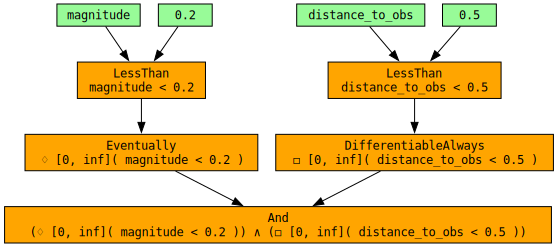

In [4]:
# defining formula

def compute_distance_to_point(states, point):
    return jnp.linalg.norm(states[...,:2] - point, axis=-1, keepdims=True)

def compute_distance_to_origin(states):
    return compute_distance_to_point(states, jnp.zeros(2))



distance_to_origin = Predicate("magnitude", compute_distance_to_origin)
distance_to_obstacle = Predicate("distance_to_obs", lambda x: compute_distance_to_point(x, obstacle_center))

reach = Eventually(distance_to_origin < 0.2)
avoid = Always(distance_to_obstacle > 0.5)
# stay = Eventually(Always(distance_to_obstacle < 0.5, interval=[0, 7]), interval=[0,20])
stay = Eventually(DifferentiableAlways(distance_to_obstacle < 0.5), interval=[0,30])
stay = DifferentiableAlways(distance_to_obstacle < 0.5)

formula = reach & stay
# formula = Until(distance_to_obstacle > 0.5, Always(distance_to_origin < 0.5), interval=[40,45])

make_stl_graph(formula)


In [5]:

def exponenial_penalty(x):
    return jnp.exp(x)

@functools.partial(jax.jit, static_argnames=("approx_method"))
def loss(controls, t_start, t_end, scale, state0, umax, dt, coeffs=[1., 0.1, 5., 0.], approx_method="true", temperature=None):
    # generate trajectory from control sequence and reverse along time dimension
    traj = simulate_dynamics(controls, state0, dt)
    # loss functions
    loss_robustness = jax.nn.relu(-formula.robustness(traj, t_start=t_start, t_end=t_end, scale=scale, approx_method=approx_method, temperature=temperature))
    loss_control_smoothness = 0 * jnp.abs(jnp.diff(controls, axis=1)).sum(-1).mean()  + (controls**2).sum(-1).mean() # make controls smoother
    loss_control_limits = jax.nn.relu(jnp.linalg.norm(controls, axis=-1) - umax).mean()   # penalize control limit violation
    min_interval = 0.2
    interval_difference = min_interval - (t_end - t_start)  # negative is good
    return coeffs[0] * loss_robustness + coeffs[1] * loss_control_smoothness + coeffs[2] * loss_control_limits + coeffs[3] * exponenial_penalty(2 * interval_difference)

@jax.jit
def true_robustness(controls, t_start, t_end, scale, state0, dt):
    # generate trajectory from control sequence and reverse along time dimension
    traj = simulate_dynamics(controls, state0, dt)
    # loss functions
    return formula.robustness(traj, t_start=t_start, t_end=t_end, scale=scale).mean()

@jax.jit
def schedule(i, i_max, start, end):
    j = (i / i_max)
    temp = anneal(j)
    return temp * (end - start) + start
    # i_ = i
    # center = i_max / 2
    # return jax.nn.sigmoid((i_ - center) / scale) * (end_temp - start_temp) + start_temp

# compare true value with max/min approximation
t_start = 0.
t_end = 0.15
scale = 0.1
loss(controls, t_start, t_end, scale, state0, umax, dt), loss(controls, t_start, t_end, scale, state0, umax, dt, approx_method="softmax", temperature=5), true_robustness(controls, t_start, t_end, scale, state0, dt)

(Array(4.257973, dtype=float32),
 Array(4.473595, dtype=float32),
 Array(-3.6283553, dtype=float32))

In [6]:
np.random.seed(123)
controls = jnp.array(np.random.randn(T,2))
t_start = -3.
t_end = -1.

t_start = -1.8
t_end = 1.5

states_ = [simulate_dynamics(controls, state0, dt)]
lr = 1E-2 # learning rate
approx_method = "logsumexp"
n_steps = 10000   # number of gradient steps
n_steps_extra = 10
coeffs = [1.1, 0.5, 2., 0.05]

# jit the gradient function to speed things up (by A LOT).
grad_jit = jax.jit(jax.grad(loss, [0,1,2]), static_argnames="approx_method")
grad_jit(controls, t_start, t_end, scale, state0, umax, dt, coeffs, approx_method, 0.2) 
# temperature schedule parameters
start_temp = 1
end_temp = 100

start_scale = 10
end_scale = 100


In [7]:

for i in range(n_steps):
    temperature = schedule(i, n_steps, start_temp, end_temp)
    scale = schedule(i, n_steps, start_scale, end_scale)
    
    t_start_ = jax.nn.sigmoid(t_start)
    t_end_ = jax.nn.sigmoid(t_end)
    g1, g2, g3 = grad_jit(controls, t_start_, t_end_, scale, state0, umax, dt, coeffs, approx_method, temperature)  # take gradient
    if (jnp.linalg.norm(g1)/ T / 2) < 5E-6:
        break
    # g =  jax.grad(loss, 0)(controls, state0, umax, approx_method, temperature)  # not jitting
    controls -= g1 * lr
    t_start -= g2 * lr * t_start_ * (1 - t_start_) 
    t_end -= g3 * lr * t_end_ * (1 - t_end_)
    # print(g2, g3, g3 * lr * t_end_ * (1 - t_end_))
    
    states_.append(simulate_dynamics(controls, state0, dt))
    if (i % 50) == 0:
        t_start_ = jax.nn.sigmoid(t_start)
        t_end_ = jax.nn.sigmoid(t_end)
        print("%3i -- true robustness: %.2f   smoothness: %.2f    control limits: %.2f    interval: %.2f t_start: %.2f    t_end: %.2f"%(i, true_robustness(controls, t_start_, t_end_, 1000., state0, dt), loss(controls, t_start_, t_end_, 1000., state0, umax, dt, coeffs=[0., 1., 0., 0.]), loss(controls, t_start_, t_end_, 1000., state0, umax, dt, coeffs=[0., 0., 1., 0.]), loss(controls, t_start_, t_end_, 1000., state0, umax, dt, coeffs=[0., 0., 0., 1.]), t_start_, t_end_))


  0 -- true robustness: -3.63   smoothness: 2.58    control limits: 0.07    interval: 0.39 t_start: 0.14    t_end: 0.82
 50 -- true robustness: -3.54   smoothness: 2.51    control limits: 0.07    interval: 0.40 t_start: 0.14    t_end: 0.80
100 -- true robustness: -3.46   smoothness: 2.45    control limits: 0.06    interval: 0.40 t_start: 0.14    t_end: 0.80
150 -- true robustness: -3.38   smoothness: 2.39    control limits: 0.05    interval: 0.40 t_start: 0.14    t_end: 0.80
200 -- true robustness: -3.30   smoothness: 2.34    control limits: 0.05    interval: 0.41 t_start: 0.15    t_end: 0.80
250 -- true robustness: -3.22   smoothness: 2.29    control limits: 0.04    interval: 0.43 t_start: 0.16    t_end: 0.78
300 -- true robustness: -3.15   smoothness: 2.24    control limits: 0.04    interval: 0.43 t_start: 0.16    t_end: 0.78
350 -- true robustness: -3.07   smoothness: 2.20    control limits: 0.03    interval: 0.43 t_start: 0.16    t_end: 0.78
400 -- true robustness: -3.00   smoothne

In [8]:
jax.nn.sigmoid(t_start) * (T+1), jax.nn.sigmoid(t_end) * (T+1)

(Array(19.07132, dtype=float32, weak_type=True),
 Array(43.92731, dtype=float32, weak_type=True))

In [9]:
formula_true = reach & Always(distance_to_obstacle < 0.5, interval=[20, 43])
formula_true.robustness(states_[-1])

Array(0.00865255, dtype=float32)

Text(0, 0.5, 'Controls')

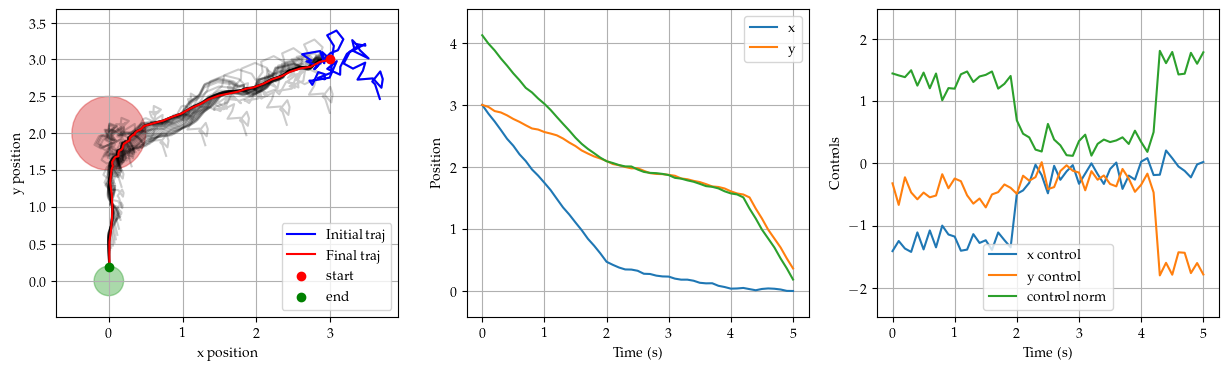

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15,4)) # note we must use plt.subplots, not plt.subplot

ax = axs[0]
circle1 = plt.Circle((0, 0), 0.2, color='C2', alpha=0.4)
circle2 = plt.Circle(obstacle_center[0], 0.5, color='C3', alpha=0.4)

ax.add_patch(circle1)
ax.add_patch(circle2)

N = 250
[ax.plot(*s.T, color="k", alpha=0.2) for s in states_[::N]]
[ax.plot(*s.T, color="blue", label="Initial traj") for s in states_[:1]]
[ax.plot(*s.T, color="r", label="Final traj") for s in states_[-1:]]

ax.scatter(states_[-1][0,:1], states_[-1][0,1:], zorder=10, label="start", color="red")
ax.scatter(states_[-1][-1,:1], states_[-1][-1,1:], zorder=10, label="end", color="green")

ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.grid()
ax.legend()
ax.axis("equal")

# plot x, y
ax = axs[1]
ax.plot(ts, states_[-1][:-1,:1], label="x")
ax.plot(ts, states_[-1][:-1,1:], label="y")
ax.plot(ts, distance_to_origin.predicate_function(states_[-1][1:]).squeeze())
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position")


# plot control signal
ax = axs[2]
ax.plot(ts, controls[:,:1], label="x control")
ax.plot(ts, controls[:,1:], label="y control")
ax.plot(ts, jnp.linalg.norm(controls, axis=-1).squeeze(), label="control norm")
ax.grid()
ax.axis("equal")
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Controls")


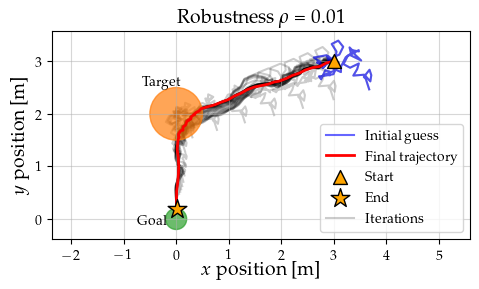

In [12]:
fontsize = 14
fig, ax = plt.subplots(figsize=(5,3)) # note we must use plt.subplots, not plt.subplot

circle1 = plt.Circle((0, 0), 0.2, color='C2', alpha=0.7)
circle2 = plt.Circle(obstacle_center[0], 0.5, color='C1', alpha=0.7)



N = 250

[ax.plot(*s.T, color="blue", label="Initial traj", alpha=0.6) for s in states_[:1]]
[ax.plot(*s.T, color="r", label="Final traj", zorder=10, linewidth=2) for s in states_[-1:]]
ax.scatter(states_[-1][0,:1], states_[-1][0,1:], zorder=10, label="start", color="orange", edgecolor="black", marker="^", s=100)
ax.scatter(states_[-1][-1,:1], states_[-1][-1,1:], zorder=10, label="end", color="orange", edgecolor="black", marker="*", s=200)

[ax.plot(*s.T, color="k", alpha=0.2, label="Iterations", zorder=0) for s in states_[::N]]
ax.add_patch(circle1)
ax.add_patch(circle2)

ax.annotate("Goal", (-0.75, -0.1))
ax.annotate("Target", (-0.65, 2.55))

ax.set_xlabel("$x$ position [m]", fontsize=fontsize, labelpad=-2)
ax.set_ylabel("$y$ position [m]", fontsize=fontsize)
ax.set_title("Robustness $\\rho$ = %.2f"%formula.robustness(states_[-1], t_start=jax.nn.sigmoid(t_start), t_end=jax.nn.sigmoid(t_end), scale=1000.), fontsize=fontsize)
ax.grid(zorder=-6, alpha=0.5)
ax.legend(["Initial guess", "Final trajectory", "Start", "End", "Iterations"], ncol=1)
ax.axis("equal")
plt.tight_layout()
# plt.savefig("figs/trajectory_optimization_diff_time.png", dpi=200, transparent=True)


True with different parameter values

In [22]:
np.random.seed(123)

bs = 51

coeffs = jnp.array([[1., 0.5, 2., p] for p in jnp.linspace(0.05, 0.55, bs)])

controls = jnp.array(np.random.randn(1,T,2)) * jnp.ones([bs, T, 2])

t_start = jnp.ones([bs]) * -1.8
t_end = jnp.ones([bs]) * 1.

states_ = [jax.vmap(simulate_dynamics, [0, None, None])(controls, state0, dt)]
lr = 1E-2 # learning rate
approx_method = "logsumexp"
n_steps = 5000   # number of gradient steps


# jit the gradient function to speed things up (by A LOT).
grad_jit = jax.jit(jax.vmap(jax.grad(loss, [0,1,2]), [0, 0, 0, None, None, None, None, 0, None, None]), static_argnames="approx_method")
g1, g2, g3 = grad_jit(controls, t_start, t_end, scale, state0, umax, dt, coeffs, approx_method, 0.2) 
# temperature schedule parameters
start_temp = 1
end_temp = 100

start_scale = 10
end_scale = 100


In [23]:

for i in range(n_steps):
    temperature = schedule(i, n_steps, start_temp, end_temp)
    scale = schedule(i, n_steps, start_scale, end_scale)
    
    t_start_ = jax.nn.sigmoid(t_start)
    t_end_ = jax.nn.sigmoid(t_end)
    g1, g2, g3 = grad_jit(controls, t_start_, t_end_, scale, state0, umax, dt, coeffs, approx_method, temperature)
    if (jnp.linalg.norm(g1)/ T / 2 / bs) < 5E-6:
        break
    controls -= g1 * lr
    t_start -= g2 * lr * t_start_ * (1 - t_start_) 
    t_end -= g3 * lr * t_end_ * (1 - t_end_)
    # print(g2, g3, g3 * lr * t_end_ * (1 - t_end_))
    
    states_.append(jax.vmap(simulate_dynamics, [0, None, None])(controls, state0, dt))
    if (i % 50) == 0:
        print(i)
    #     t_start_ = jax.nn.sigmoid(t_start)
    #     t_end_ = jax.nn.sigmoid(t_end)
    #     true_rob = true_robustness(controls, t_start_, t_end_, 1000., state0, dt)
        
        
        # print("%3i -- true robustness: %.2f   smoothness: %.2f    control limits: %.2f    interval: %.2f t_start: %.2f    t_end: %.2f"%(i, true_robustness(controls, t_start_, t_end_, 1000., state0, dt), loss(controls, t_start_, t_end_, 1000., state0, umax, dt, coeffs=[0., 1., 0., 0.]), loss(controls, t_start_, t_end_, 1000., state0, umax, dt, coeffs=[0., 0., 1., 0.]), loss(controls, t_start_, t_end_, 1000., state0, umax, dt, coeffs=[0., 0., 0., 1.]), jax.nn.sigmoid(t_start_), jax.nn.sigmoid(t_end)))


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950


In [24]:
starts = jax.nn.sigmoid(t_start)
ends = jax.nn.sigmoid(t_end)

true_rob = jax.vmap(true_robustness, [0, 0, 0, None, None, None])(controls, starts, ends, 1000., state0, dt)
smoothness = jax.vmap(loss, [0, 0, 0, None, None, None, None, None])(controls, starts, ends, 1000., state0, umax, dt, [0., 1., 0., 0.])
limits = jax.vmap(loss, [0, 0, 0, None, None, None, None, None])(controls, starts, ends, 1000., state0, umax, dt, [0., 0., 1., 0.])
bounds = jax.vmap(loss, [0, 0, 0, None, None, None, None, None])(controls, starts, ends, 1000., state0, umax, dt, [0., 0., 0., 1.]), 


In [25]:
@interact(i=(0, bs))
def foo(i):
    fontsize = 14
    fig, ax = plt.subplots(figsize=(5,4)) # note we must use plt.subplots, not plt.subplot

    circle1 = plt.Circle((0, 0), 0.2, color='C2', alpha=0.4)
    circle2 = plt.Circle(obstacle_center[0], 0.5, color='C3', alpha=0.4)



    N = 250

    [ax.plot(s[:,0], s[:,1], color="blue", label="Initial traj", alpha=0.6) for s in states_[0][:1]]
    [ax.plot(s[:,0], s[:,1], color="r", label="Final traj", zorder=10, linewidth=2) for s in states_[-1][i:i+1]]
    ax.scatter(states_[-1][i][0,:1], states_[-1][i][0,1:], zorder=10, label="start", color="orange", edgecolor="black", marker="^", s=100)
    ax.scatter(states_[-1][i][-1,:1], states_[-1][i][-1,1:], zorder=10, label="end", color="orange", edgecolor="black", marker="*", s=200)

    [ax.plot(s[i,:,0], s[i,:,1], color="k", alpha=0.2, label="Iterations", zorder=0) for s in states_[::N]]
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    ax.annotate("Goal", (-0.75, -0.1))
    ax.annotate("Target", (-0.65, 2.55))

    ax.set_xlabel("x position", fontsize=fontsize, labelpad=-2)
    ax.set_ylabel("y position", fontsize=fontsize)
    ax.set_title(" $\\rho$ = %.2f, $\\gamma_3$=%.2f, [a,b]=[%.2f, %.2f]"%(true_rob[i], coeffs[i][-1], starts[i], ends[i]))
    ax.grid(zorder=-6, alpha=0.5)
    ax.legend(["Initial guess", "Final trajectory", "Start", "End", "Iterations"])
    ax.axis("equal")
    # ax.set_xlim([-1, 1])
    # ax.set_ylim([-0.5, 3.5])
    plt.tight_layout()


interactive(children=(IntSlider(value=25, description='i', max=51), Output()), _dom_classes=('widget-interact'…

In [29]:
import imageio.v2 as imageio

images = []
for i in range(bs):
    foo(i)
    filename = f"gifs/trajectory_opt_diff_time_coefficients_{i}.png"
    plt.savefig(filename)  # Save to file
    plt.close()  # Close the plot to start fresh in the next iteration
    
    # Append the filename to the list
    images.append(imageio.imread(filename)) 
imageio.mimsave('gifs/trajectory_opt_diff_time_coefficients_test.gif', images, duration=100, loop=0)  # fps controls the frame rate

print("GIF created successfully!")

GIF created successfully!


Text(0.5, 1.0, ' $\\rho$ = -0.55, $\\gamma_3$=0.10')

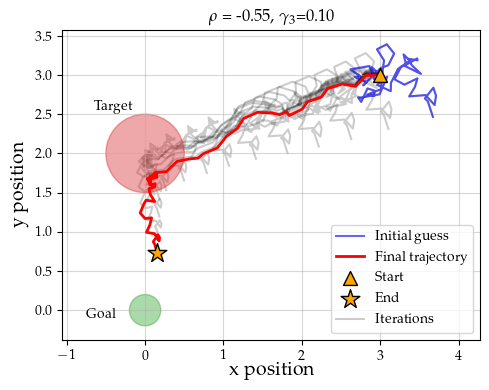

In [21]:
foo(5)
plt.title(" $\\rho$ = %.2f, $\\gamma_3$=%.2f"%(true_rob[5], coeffs[5][-1]))
# plt.savefig("figs/trajectory_optimization_diff_time.png", dpi=500, transparent=True)